In [23]:
import numpy as np
import networkx as nx
from ipysigma import Sigma
import matplotlib.pyplot as plt

np.random.seed(0)

In [24]:
class Mutation:
    count = 0

    @staticmethod
    def new(n):
        start = Mutation.count
        Mutation.count += n
        stop = Mutation.count
        return range(start, stop)

In [25]:
class Node:
    node_count = 0
    all_nodes = []
    def __init__(self, t):
        self.id = Node.node_count
        Node.node_count += 1
        Node.all_nodes.append(self)
        
        self.t = t
        self.parent = None
        self.children = []
        self.mutated = False
        self.mut_count = 0

    def get_label(self):
        label = f"{self.id} ({self.t})"
        if self.mutated:
            label += f" {self.mut_count}"
        return label

    def print(self, indent=0):
        print("  " * indent + self.get_label())
        for child in self.children:
            child.print(indent + 1)

    def adopt(self, child):
        self.children.append(child)
        child.parent = self

    def mutate(self, rate):
        assert self.mutated is False
        assert self.parent is not None
        self.mutated = True
        self.mut_count = np.random.poisson(rate * (self.t - self.parent.t))
        return self.mut_count

    def to_networkx(self):
        G = nx.DiGraph()
        G.add_node(self.id, label=self.get_label())
        for child in self.children:
            G.add_edge(self.id, child.id)
            G = nx.compose(G, child.to_networkx())
        return G

In [26]:
def get_lineage(node):
    path = [node]
    while path[-1].parent is not None:
        path.append(path[-1].parent)
    return reversed(path)

def get_common_ancestor(nodes):
    lineages = [list(get_lineage(node)) for node in nodes]
    common_ancestor = None
    for ancestors in zip(*lineages):
        if len(set(ancestors)) == 1:
            common_ancestor = ancestors[0]
        else:
            break
    return common_ancestor

In [27]:
def count_descendants(root, target_nodes, return_dict):
    # count number of descendants of root that are in target_nodes
    count = 1 if root in target_nodes else 0
    for child in root.children:
        count += count_descendants(child, target_nodes, return_dict)
    return_dict[root.id] = count
    return count

In [28]:
def coalesce(pop_size, sample_size, initial_t, final_t):
    # Simulate a coalescent tree
    t = final_t

    leaves = [Node(t) for _ in range(sample_size)]
    orphans = leaves.copy()

    while len(orphans) > 1:
        tmean = 2 * pop_size / (sample_size * (sample_size - 1))
        t -= np.random.exponential(tmean)

        if t < initial_t:
            break

        # Pick two orphans to coalesce, remove then from the list of orphas
        node1 = np.random.choice(orphans)
        orphans.remove(node1)

        node2 = np.random.choice(orphans)
        orphans.remove(node2)

        # Create a new node that is the parent of the two orphans
        parent = Node(t)
        parent.adopt(node1)
        parent.adopt(node2)

        # Add the parent to the list of orphans
        orphans.append(parent)

    return orphans, leaves

In [29]:
class Individual:
    def __init__(self, t, origin, n_pop, n_sample, mut_rate):
        self.t = t
        self.origin = origin
        self.n_pop = n_pop
        self.n_sample = n_sample
        self.mut_rate = mut_rate

        self.sample = [Node(t) for _ in range(n_sample)]
        for node in self.sample:
            origin.adopt(node)

    def evolve(self, dt):
        # Coalesce the sample and get the orphans and leaves
        orphans, leaves = coalesce(self.n_pop, self.n_sample, self.t, self.t + dt)

        # Pick the parents of the orphans
        parents = np.random.choice(self.sample, len(orphans), replace=False)

        # Adopt the orphans
        for parent, orphan in zip(parents, orphans):
            parent.adopt(orphan)

        for orphan in orphans:
            orphan.mutate(self.mut_rate)

        self.sample = leaves
        self.t += dt

    def contaminate(self):
        # return a new individual originating from a random node in the sample
        origin = np.random.choice(self.sample)
        return Individual(self.t, origin, self.n_pop, self.n_sample, self.mut_rate)

In [30]:
n_pop = 1e5
n_sample = 10
mut_rate = 0.1
T = 1e5

t = 0
origin = Node(t)
a = Individual(t, origin, n_pop, n_sample, mut_rate)
a.evolve(T)
b = a.contaminate()
a.evolve(T)
b.evolve(T)
c = b.contaminate()
a.evolve(T)
b.evolve(T)
c.evolve(T)


G = origin.to_networkx()
# set colors for the nodes in the sample
for node in a.sample:
    G.nodes[node.id]["color"] = "red"
for node in b.sample:
    G.nodes[node.id]["color"] = "blue"
for node in c.sample:
    G.nodes[node.id]["color"] = "green"
for node in Node.all_nodes:
    if node.mutated:
        G.nodes[node.id]["color"] = "black"
Sigma(G, hide_info_panel=True)

Sigma(nx.DiGraph with 145 nodes and 144 edges)

In [31]:
def get_mutation_profile(individual):
    r = get_common_ancestor(individual.sample)
    descendants = {}
    count_descendants(r, individual.sample, descendants)
    # sort by number of descendants
    descendants = {k: v for k, v in sorted(descendants.items(), key=lambda item: item[1], reverse=True)}
    # ignore fixed mutations
    descendants = {k: v for k, v in descendants.items() if 0 < v < n_sample}

    mutation_profile = []
    for k, v in descendants.items():
        node = Node.all_nodes[k]
        repeat = node.mut_count
        mutation_profile.extend([v] * repeat)
    return mutation_profile

def get_number_of_non_fixated_mutations(individual):
    r = get_common_ancestor(individual.sample)
    descendants = {}
    count_descendants(r, individual.sample, descendants)
    # sort by number of descendants
    descendants = {k: v for k, v in sorted(descendants.items(), key=lambda item: item[1], reverse=True)}
    # ignore fixed mutations
    descendants = {k: v for k, v in descendants.items() if 0 < v < n_sample}

    ans = 0
    for k, v in descendants.items():
        node = Node.all_nodes[k]
        repeat = node.mut_count
        ans += repeat
    return ans


Number of non-fixated mutations in individual a: 0
Number of non-fixated mutations in individual b: 0
Number of non-fixated mutations in individual c: 0


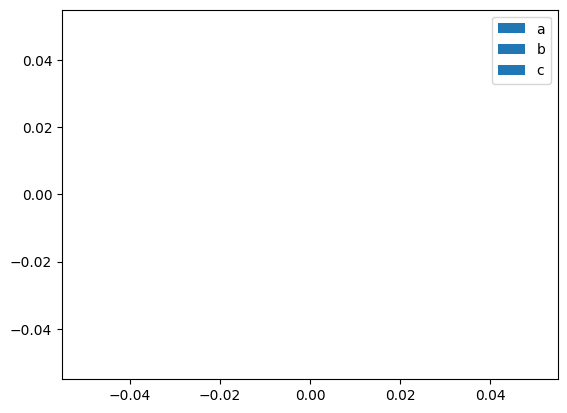

In [32]:
for individual, label in [(a, "a"), (b, "b"), (c, "c")]:
    mutation_profile = get_mutation_profile(individual)
    print(f"Number of non-fixated mutations in individual {label}: {len(mutation_profile)}")
    plt.bar(range(len(mutation_profile)), np.array(mutation_profile) / individual.n_sample, label=label, alpha=0.5)
plt.legend()
plt.show()

In [33]:
# # study the distribution of non-fixated mutations
# def simulate(n_pop, n_sample, mut_rate, T, n_simulations):
#     results = []
#     for _ in range(n_simulations):
#         t = 0
#         origin = Node(t)
#         individual = Individual(t, origin, n_pop, n_sample, mut_rate)
#         individual.evolve(T)
#         results.append(get_number_of_non_fixated_mutations(individual))
#         # return mean and standard deviation
#     mean = np.mean(results)
#     std = np.std(results)
#     return mean, std

# n_simulations = 10
# n_pop = 10000
# n_sample = 100
# mut_rate = 1e-3
# T_max = 1000
# n_points = 200
# Ts = np.linspace(0, T_max, n_points)
# results = [simulate(n_pop, n_sample, mut_rate, T, n_simulations) for T in Ts]
# means, stds = zip(*results)

# subtitle = f"n_pop={n_pop}, n_sample={n_sample}, mut_rate={mut_rate}"
# plt.title(f"Number of non-fixated mutations over time\n({subtitle})")
# plt.errorbar(Ts, means, yerr=stds, fmt='o')
# plt.xlabel("Time")
# plt.ylabel("Number of non-fixated mutations")
# # horizontal line at n_pop * mut_rate
# plt.axhline(n_pop * mut_rate, color='red', linestyle='--', label="n_pop * mut_rate")

# # find first time when the number of non-fixated mutations is greater than n_pop * mut_rate
# for i, (mean, std) in enumerate(results):
#     if mean > n_pop * mut_rate:
#         print(f"First time when number of non-fixated mutations > n_pop * mut_rate: {Ts[i]}")
#         break
# plt.legend()
# plt.show()